# Figure of new western boundary conditions to incorporate Pacific water inflow / wBSW

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import scipy.ndimage as ndimage
import matplotlib
import xarray as xr
import gsw

%matplotlib inline

#### Parameters:

In [2]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

In [3]:
rimwidth_north = 10 # western Canada Basin
rimwidth_east  = 20 # northern Canada Basin
rimwidth_south = 10 # Baffin Bay

In [4]:
land_color         = '#a9a7a2'
land_outline_color = '#373736'

In [5]:
N_coordinates = ((2168, 2178, 201, 798))
E_coordinates = ((1481, 2178, 778, 798))
S_coordinates = ((1482, 1492, 181, 798))

#### Functions:

#### Load files:

In [6]:
ref       = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2015m01d05.nc',  'r')
lat_model = np.array(ref.variables['nav_lat'])
lon_model = np.array(ref.variables['nav_lon'])

In [7]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = np.array(mesh.variables['nav_lev'])
mesh_hdept   = np.array(mesh.variables['hdept'])[0]

In [8]:
Nmn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_North_OBC_20220422.nc')
dMn_north_old = np.reshape(np.array(Nmn.variables['dMn'])[0,:,0,:], (50,10,597))

Nmn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_North_OBC_ACC_20220422.nc')
dMn_north_new = np.reshape(np.array(Nmn.variables['dMn'])[0,:,0,:], (50,10,597))

#### Figures:

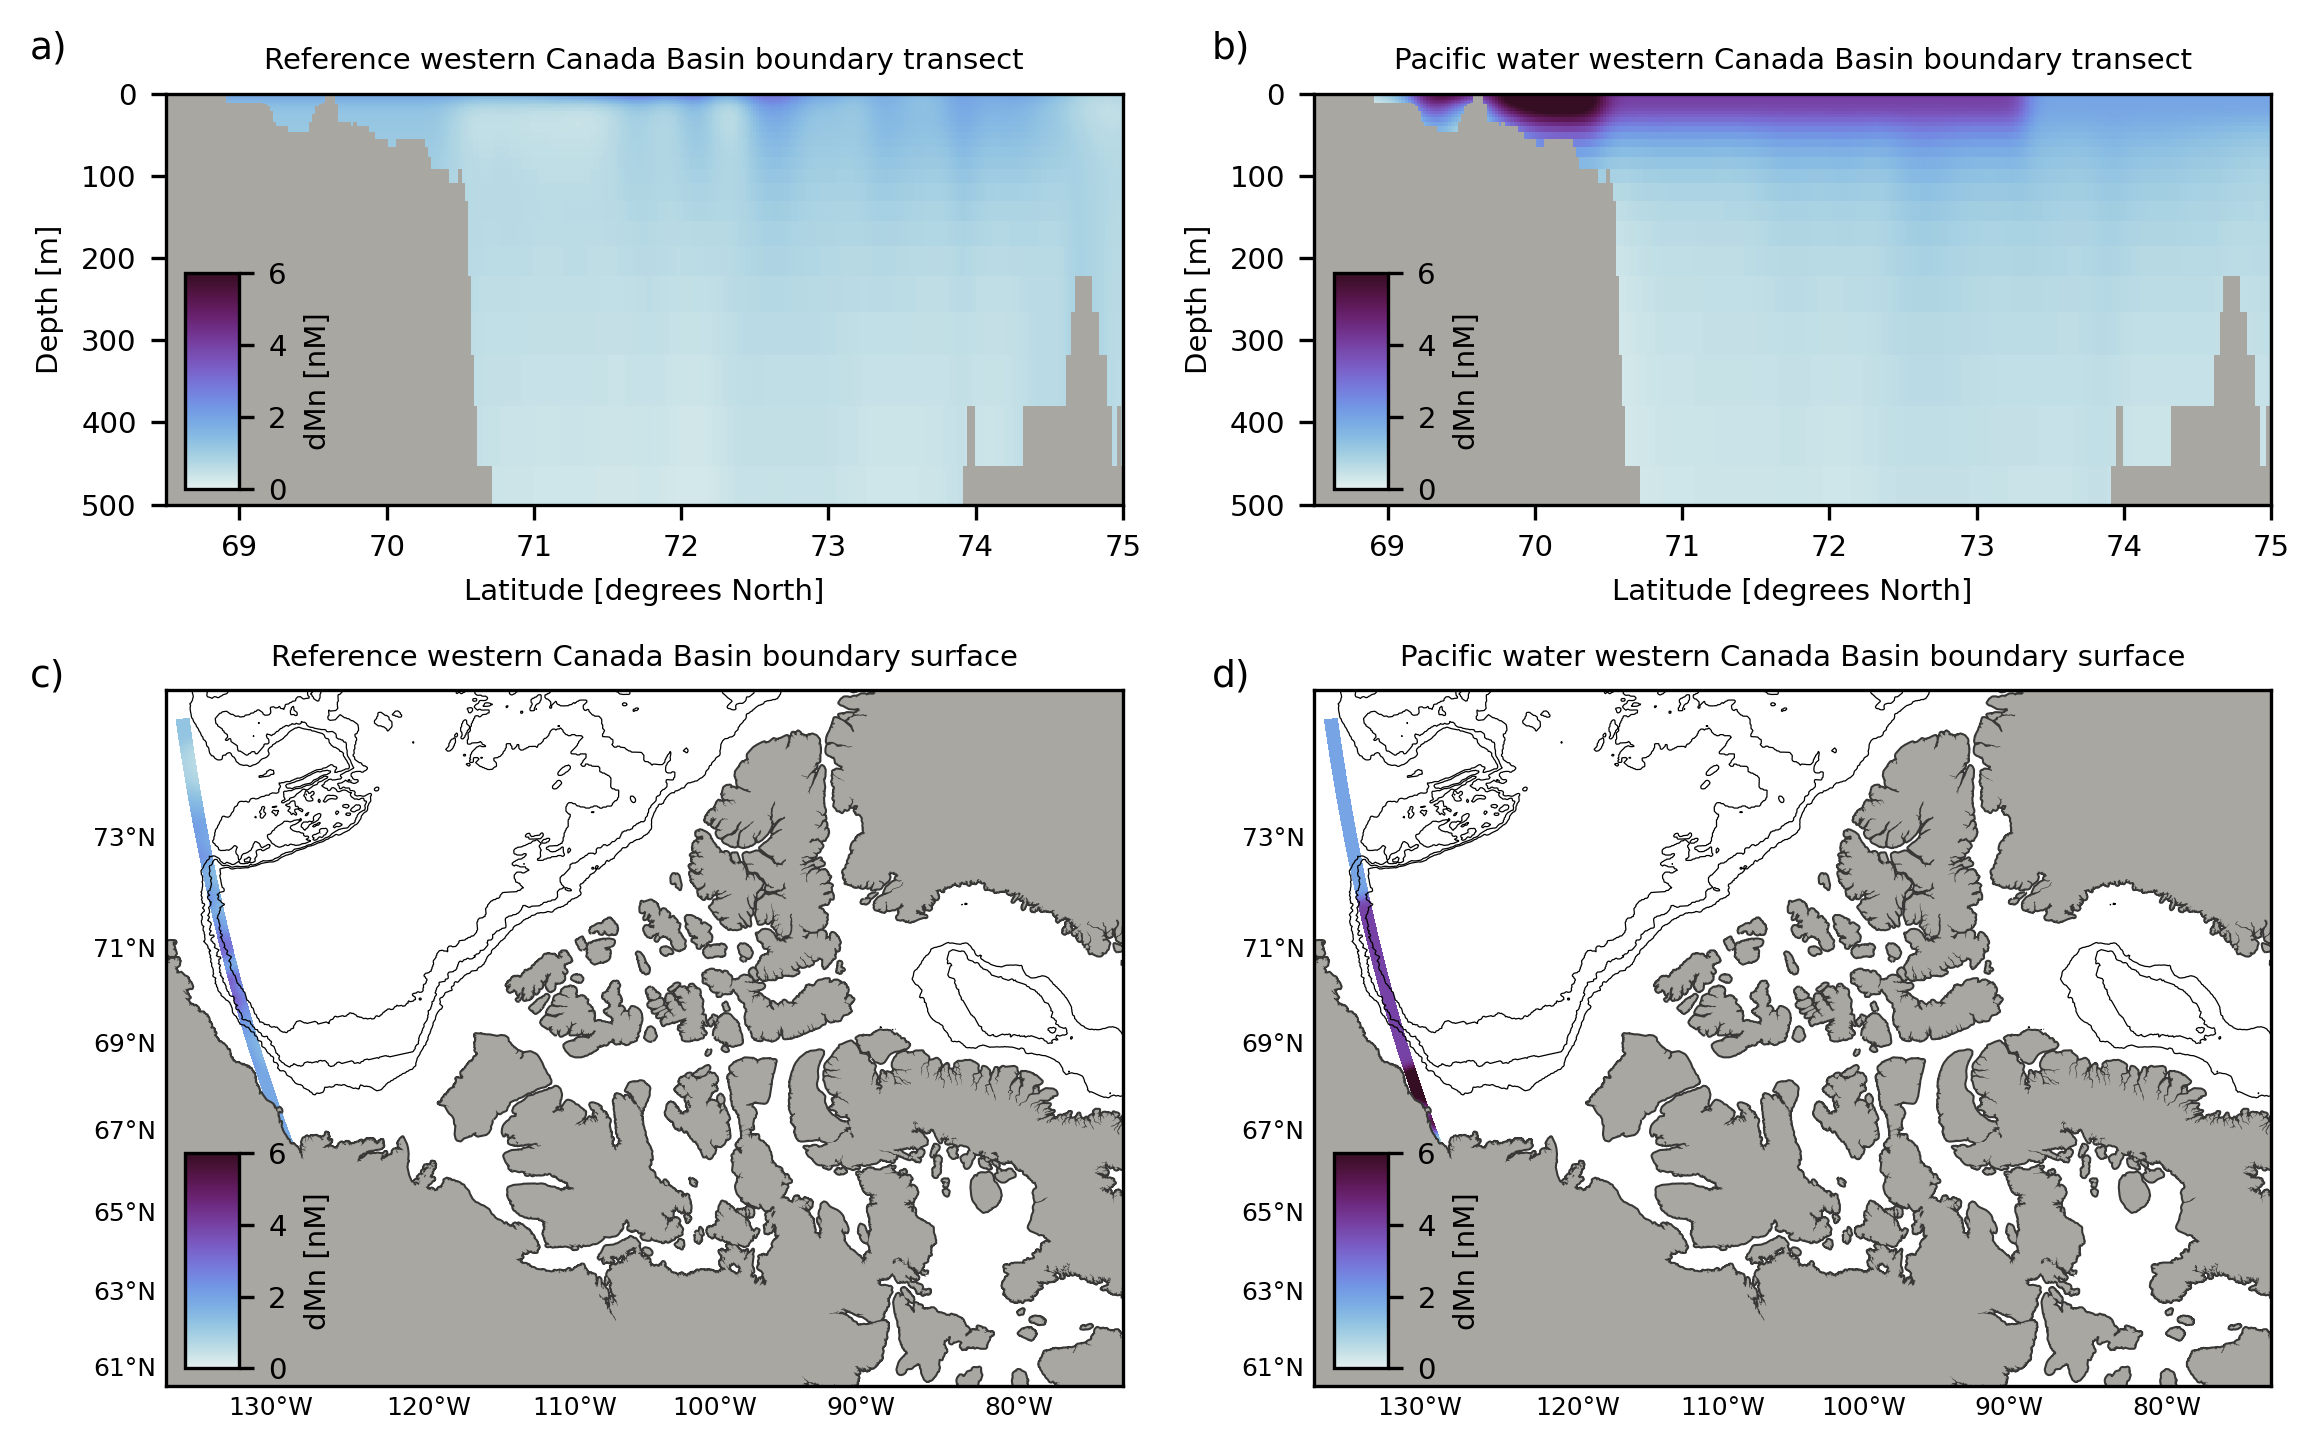

In [10]:
(bdyimin, bdyimax, bdyjmin, bdyjmax) = N_coordinates
    
layer=0
# Latitude of boundary:
lats_bdy = lat_model[bdyimin:bdyimax,bdyjmin:bdyjmax]
mesh_bathy_bdy = bathy_masked[:,bdyimin+layer,bdyjmin:bdyjmax]
lats           = lats_bdy[layer,:]
    
# Figure:
fig, ax = plt.subplots(2,2, figsize=(9.055, 3.74*1.6), dpi=300, gridspec_kw={'height_ratios': [1, 2]}) #gridspec_kw={'width_ratios': [1, 2]})
        
# boundaries (top panels): 
CB1 = ax[0,0].pcolormesh(lats, mesh_depth, dMn_north_old[:,layer,:]*1e9, vmin=0, vmax=6, cmap=cmocean.cm.dense, zorder=1)
CB2 = ax[0,1].pcolormesh(lats, mesh_depth, dMn_north_new[:,layer,:]*1e9, vmin=0, vmax=6, cmap=cmocean.cm.dense, zorder=1)
    
# labels
for axis in ax[0,:].ravel():
    axis.set_ylabel('Depth [m]', fontsize=7)
    axis.set_xlabel('Latitude [degrees North]', fontsize=7)
    axis.invert_yaxis()
    axis.pcolormesh(lats, mesh_depth, mesh_bathy_bdy, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)
    axis.set_ylim(500,0)
    axis.set_xlim(68.5,75)
    axis.tick_params(axis='both', labelsize=7)
    
ax[0,0].set_title("Reference western Canada Basin boundary transect", fontsize=7)
ax[0,1].set_title("Pacific water western Canada Basin boundary transect", fontsize=7)

# colorbars:
cbar_ax1 = fig.add_axes([0.132, 0.66, 0.02, 0.12])
cbar_ax2 = fig.add_axes([0.555, 0.66, 0.02, 0.12])
cbar1 = plt.colorbar(CB1, cax=cbar_ax1)
cbar2 = plt.colorbar(CB2, cax=cbar_ax2, label='dMn [nM]')
    
#------------- Maps: ---------------------------
proj1 = Basemap(projection='stere',lat_0 = 75.1, lon_0 = -105, resolution='i', width=3.3e6, height=2.4e6, ax=ax[1,0])
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=6)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=6)
proj1.drawcoastlines(color=land_outline_color, linewidth=1.0)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

proj2 = Basemap(projection='stere',lat_0 = 75.1, lon_0 = -105, resolution='i', width=3.3e6, height=2.4e6, ax=ax[1,1])
proj2.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=6)
proj2.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=6)
proj2.drawcoastlines(color=land_outline_color, linewidth=1.0)
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

# add bathymetry contours:
x, y = proj1(lon_model, lat_model)
proj1.contour(x, y, mesh_hdept, levels=[1000,2000,3000], linewidths=0.3, colors='k', zorder=3)
proj2.contour(x, y, mesh_hdept, levels=[1000,2000,3000], linewidths=0.3, colors='k', zorder=3)

xN, yN = proj1(lon_model[N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]], \
               lat_model[N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]])
CB3 = proj1.pcolormesh(xN, yN, dMn_north_old[0,:,:]*10**9, vmin=0, vmax=6, cmap=cmocean.cm.dense)
CB4 = proj2.pcolormesh(xN, yN, dMn_north_new[0,:,:]*10**9, vmin=0, vmax=6, cmap=cmocean.cm.dense)

ax[1,0].set_title("Reference western Canada Basin boundary surface", fontsize=7)
ax[1,1].set_title("Pacific water western Canada Basin boundary surface", fontsize=7)

cbar_ax3 = fig.add_axes([0.132, 0.17, 0.02, 0.12])
cbar_ax4 = fig.add_axes([0.555, 0.17, 0.02, 0.12])
cbar3 = plt.colorbar(CB3, cax=cbar_ax3) 
cbar4 = plt.colorbar(CB4, cax=cbar_ax4) 

for cbar in [cbar1, cbar2, cbar3, cbar4]:
    cbar.ax.tick_params(labelsize=7) 
    cbar.set_label(label='dMn [nM]',size=7)
    
fig.text(0.075, 0.90, 'a)', fontsize=9);
fig.text(0.51 , 0.90, 'b)', fontsize=9);
fig.text(0.075, 0.55, 'c)', fontsize=9);
fig.text(0.51 , 0.55, 'd)', fontsize=9);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S16-western-boundary.jpg', bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S16-western-boundary.svg', bbox_inches='tight', dpi=300, format='svg')

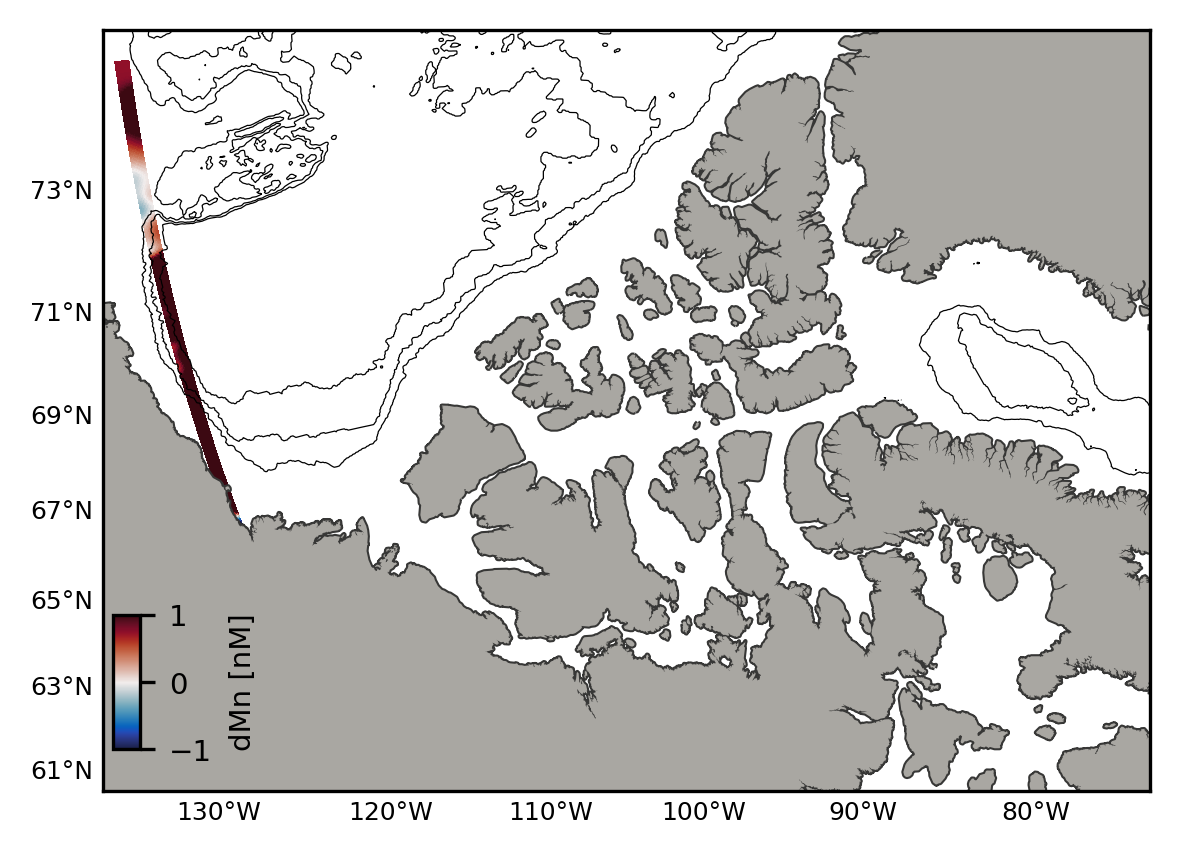

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4.5, 3.74), dpi=300)        

proj1 = Basemap(projection='stere',lat_0 = 75.1, lon_0 = -105, resolution='i', width=3.3e6, height=2.4e6, ax=ax)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=6)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=6)
proj1.drawcoastlines(color=land_outline_color, linewidth=1.0)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

# add bathymetry contours:
x, y = proj1(lon_model, lat_model)
proj1.contour(x, y, mesh_hdept, levels=[1000,2000,3000], linewidths=0.3, colors='k', zorder=3)
xN, yN = proj1(lon_model[N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]], \
               lat_model[N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]])
CB1 = proj1.pcolormesh(xN, yN, dMn_north_new[0,:,:]*10**9 - dMn_north_old[0,:,:]*10**9, vmin=-1, vmax=1, cmap=cmocean.cm.balance)

cbar_ax1 = fig.add_axes([0.15, 0.2, 0.02, 0.12])
cbar1 = plt.colorbar(CB1, cax=cbar_ax1) 
cbar1.ax.tick_params(labelsize=7) 
cbar1.set_label(label='dMn [nM]',size=7)